<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [2]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import plotly.graph_objects as go # for visualization
import os
import sys 
sys.path.append("../../Function/")
import function 

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [3]:
# Importing Training Set
df = pd.read_excel('../../../site_info_ver_4_lite.xlsx')


In [4]:
dataset = df.copy()
# dataset = dataset.loc[dataset.Israelis_Count<30000]
dataset.drop(['so2','nox','pm10','pm2.5','is_Site_exceeded_nox', 'is_Site_exceeded_so2', 'is_Site_exceeded_pm10', 'is_Site_exceeded_pm2.5','Day_before_Total','Tourists_Count', 'Total'],axis=1,inplace=True)
dataset = function.remove_unique_one(dataset)
dataset = function.remove_high_corr(dataset, 'Israelis_Count',0.3)
# dataset = function.remove_outliers(dataset, 'Israelis_Count')
dataset = function.split_date(dataset)
tmp = dataset.Israelis_Count
dataset.drop('Israelis_Count',axis=1,inplace=True)
dataset = pd.get_dummies(dataset,'')
dataset['Israelis_Count']=tmp
dataset.set_index('Date',inplace=True)
dataset.sort_index(inplace=True)
# dataset.set_index('Date',inplace=True)
print(dataset.columns)
dataset.head(1)

Split Data Successfully
Index(['is_weekend', 'operations', 'is_jewish_holiday', 'is_muslims_holiday',
       'is_muslims_vacation', 'is_jewishHeritage', 'is_natureReserve',
       'is_archaeology', 'is_animals', 'Haifa_pm2.5', 'Haifa_so2',
       'Ashkelon_so2', 'Beer-Sheva_so2', 'Tel_Aviv-Yafo_pm10_exceeded',
       'Ashkelon_pm10_exceeded', 'Jerusalem_pm2.5_exceeded',
       'Haifa_pm2.5_exceeded', 'Ashkelon_pm2.5_exceeded',
       'Tel_Aviv-Yafo_nox_exceeded', 'Jerusalem_nox_exceeded',
       'Haifa_nox_exceeded', 'Green_border', 'Season_autumn', 'Season_winter',
       'day', 'month', 'year', '_Eilat Coral Beach', '_En Afek', '_En Gedi',
       '_En Prat', '_Enot Tsukim', '_Gan HaShlosha', '_Hermon Stream (Banias)',
       '_The Masada', 'Israelis_Count'],
      dtype='object')


,is_weekend,operations,is_jewish_holiday,is_muslims_holiday,is_muslims_vacation,is_jewishHeritage,is_natureReserve,is_archaeology,is_animals,Haifa_pm2.5,...,year,_Eilat Coral Beach,_En Afek,_En Gedi,_En Prat,_Enot Tsukim,_Gan HaShlosha,_Hermon Stream (Banias),_The Masada,Israelis_Count
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-01,1,0,0,0,0,0,1,0,0,26.2,...,2016,1,0,0,0,0,0,0,0,35


In [5]:
# size=round(len(dataset)*.8)
# dataset_train = dataset[:size]
# dataset_test = dataset[size:]
X = dataset.drop(['Israelis_Count'],axis=1)
y = dataset.Israelis_Count

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,shuffle=False,test_size=0.3,random_state=312148513)

from sklearn.preprocessing import MinMaxScaler 
train_scaler = MinMaxScaler()
test_scaler = MinMaxScaler()
train_scaler_y = MinMaxScaler()
test_scaler_y = MinMaxScaler()

X_train_scaled = train_scaler.fit_transform(X_train)
y_train_scaled = np.log([y_train.values+0.01]).T
y_train_scaled = np.reshape(y_train_scaled, y_train_scaled.shape[0])

X_test_scaled = test_scaler.fit_transform(X_test)
y_test_scaled = np.log([y_test.values+0.01]).T
y_test_scaled = np.reshape(y_test_scaled, y_test_scaled.shape[0])

print('shape X train',X_train_scaled.shape)
print('shape y train',y_train_scaled.shape)
print('shape X test',X_test_scaled.shape)
print('shape y test',y_test_scaled.shape)

shape X train (10324, 35)
shape y train (10324,)
shape X test (4425, 35)
shape y test (4425,)


<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [6]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# from keras.optimizers import ADAM

In [7]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Initializing the Neural Network based on LSTM
model = Sequential()

model.add(Dense(units=2048,activation='relu',input_shape=(X_train_scaled.shape[1],)))
# Adding Dropout
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation='relu'))
# Adding Dropout
model.add(Dropout(0.5))
model.add(Dense(units=1024,activation='relu'))
# Adding Dropout
model.add(Dropout(0.5))
model.add(Dense(units=128,activation='relu'))
# Adding Dropout
model.add(Dropout(0.25))
model.add(Dense(units=64,activation='relu'))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=4,activation='relu'))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1,activation='relu'))

# Compiling the Neural Network
model.compile(optimizer = 'adam', loss='mean_squared_error',metrics=['mean_squared_error'])

<h3>Step #4. Start training</h3>

In [8]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train_scaled, shuffle=True, epochs=1000, callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=5)

Epoch 1/1000
1652/1652 [==============================] - ETA: 0s - loss: 6.5408 - mean_squared_error: 6.5408
Epoch 00001: val_loss improved from inf to 3.03949, saving model to weights.h5
1652/1652 [==============================] - 40s 24ms/step - loss: 6.5408 - mean_squared_error: 6.5408 - val_loss: 3.0395 - val_mean_squared_error: 3.0395 - lr: 0.0010
Epoch 2/1000
1652/1652 [==============================] - ETA: 0s - loss: 3.7214 - mean_squared_error: 3.7214
Epoch 00002: val_loss improved from 3.03949 to 1.45973, saving model to weights.h5
1652/1652 [==============================] - 40s 24ms/step - loss: 3.7214 - mean_squared_error: 3.7214 - val_loss: 1.4597 - val_mean_squared_error: 1.4597 - lr: 0.0010
Epoch 3/1000
1650/1652 [============================>.] - ETA: 0s - loss: 2.7027 - mean_squared_error: 2.7027
Epoch 00003: val_loss improved from 1.45973 to 1.27286, saving model to weights.h5
1652/1652 [==============================] - 40s 24ms/step - loss: 2.7011 - mean_squared_

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [9]:
# # Generate list of sequence of days for predictions
# datelist_future = pd.date_range(datelist_train[-1], periods=n_predict, freq='1d').tolist()
# datelist_future


<h3>Step #5. Make predictions for future dates</h3>

In [10]:
# Perform predictions
model.load_weights('weights.h5')
predictions_future = model.predict(X_test)
len(predictions_future)
# predictions_train = model.predict(X_train[n_past:])

4425

<h3>Step #6. Visualize the Predictions</h3>

(4425,)
rmse 619.7578146342239
std 694.4558716883619


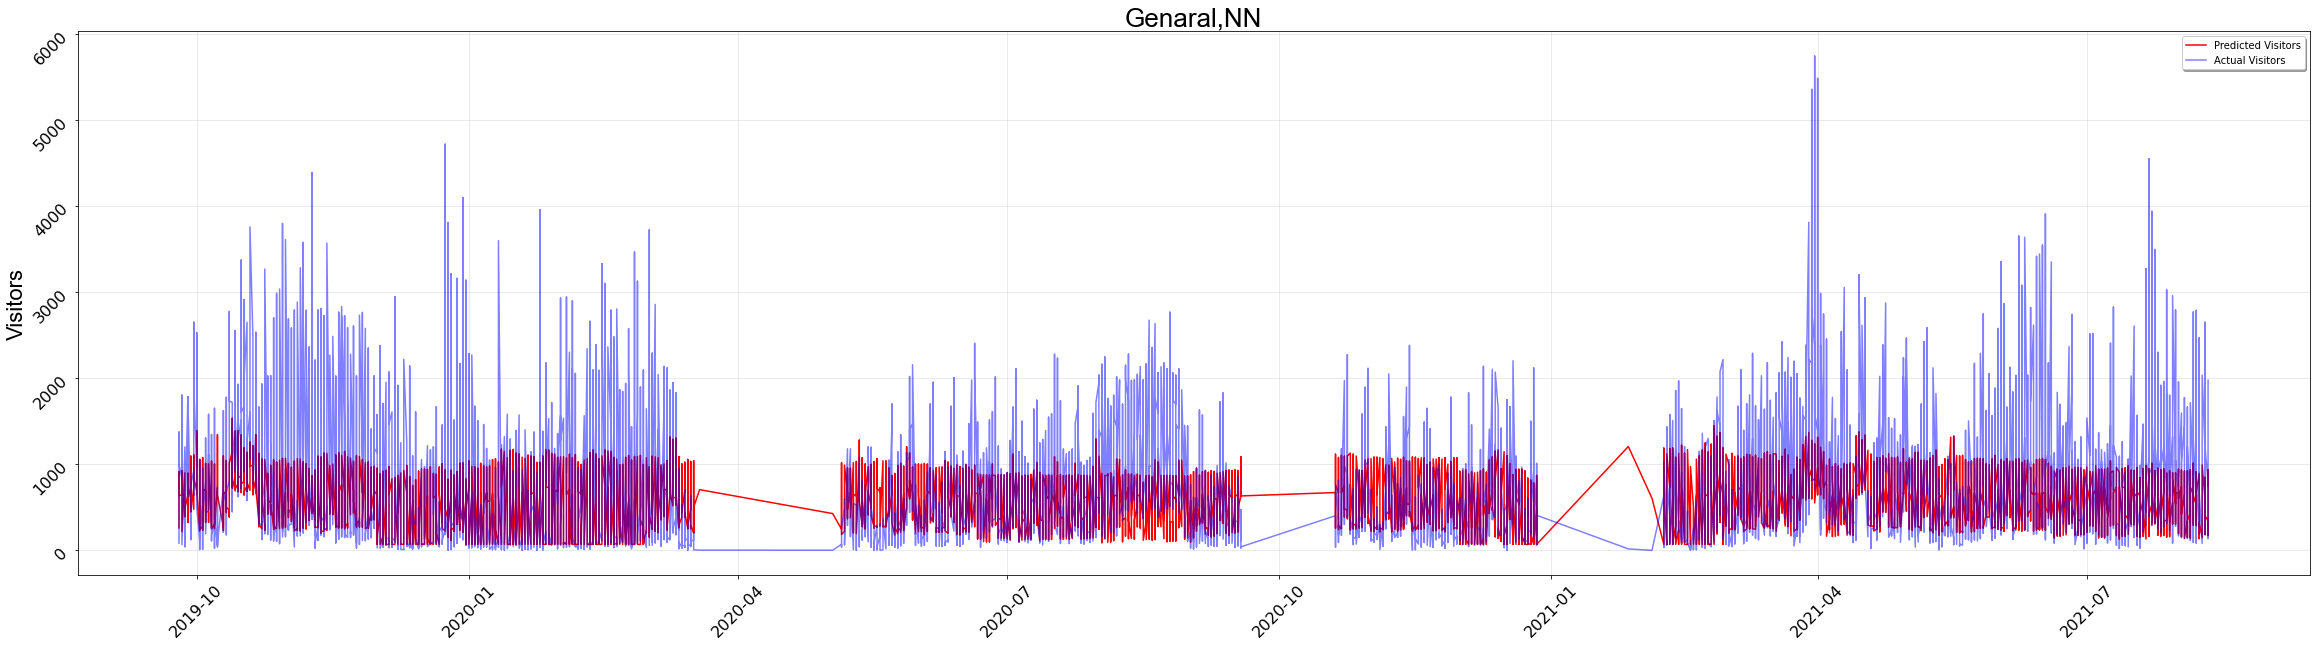

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


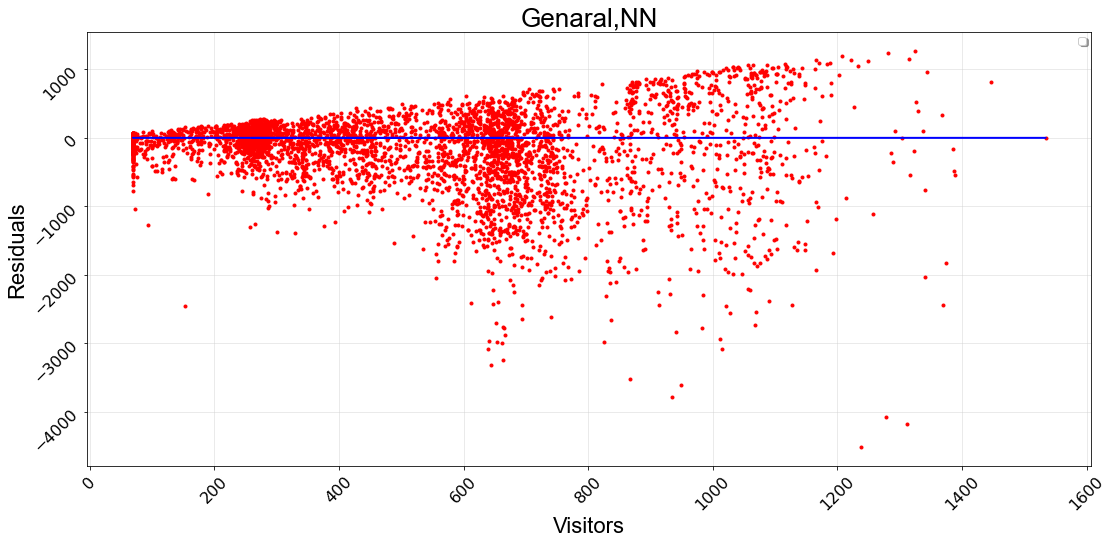

In [11]:
prediction_scaled = model.predict(X_test_scaled)
prediction_scaled = np.reshape(prediction_scaled,prediction_scaled.shape[0])
prediction = np.exp([prediction_scaled]).T
prediction = np.reshape(prediction,prediction.shape[0])
print(prediction.shape)
res  = pd.DataFrame(data={
    'Prediction':prediction,
    'Actual':y_test.values} , index=y_test.index
    )


title='Genaral,NN'
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))


res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual,alpha_actual=0.5,alpha_prediction=1,fig_size_tuple=(40,10),title=title)
function.plot_residuals(res.Prediction, res.Actual,title=title)


In [12]:
X_train_scaled.values

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
import lime
import lime.lime_tabular
# from lime.lime_text import RecurrentTabularExplainer
class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 10).flatten()
print(X_train.columns.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = lime.lime_tabular.LimeTabularExplainer( X_train_scaled, 
                                                   feature_names=X_train.columns, 
                                                   class_names=['price'], 
                                                   categorical_features=categorical_features, 
                                                   verbose=True, mode='regression')


In [ ]:
exp = explainer.explain_instance(X_test_scaled[0],model.predict,num_features=10)
exp.show_in_notebook(show_table=True)


**What is the meaning of that?**


* left - we can see the 92th test value’s prediction
* middle - important (significant) features: directions and ranges for the prediction
* right - summary of results